## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpImg
import glob
import sys
from helperFunctions import *
%matplotlib inline


##  1. Compute the camera calibration using chessboard images:

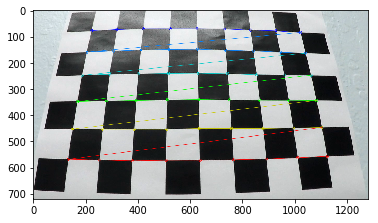

In [2]:

#calibrateCam takes the folder path as an argument and return mtx, dist,
# and an array of images with chessboard corners drawn on them.
mtx, dist, calibrationImgs = calibrateCam(folderPath="camera_cal/", nx=9, ny=6)
# Display a sample Chessboard with corners image.
plt.imshow(calibrationImgs[2])

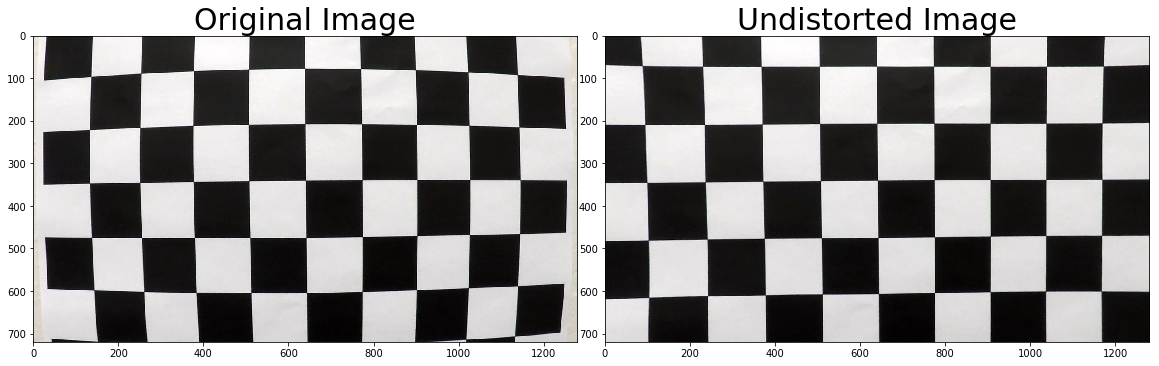

In [3]:
# read one test image from the calibration image set and undistort it.
imgPathList = glob.glob('camera_cal/calibration*.jpg')
distorted = cv2.imread(imgPathList[6]) # grab a sample distorted, test image.
undistortedImg = undistort(distorted, mtx, dist)

display2ImgsSideBySide('Original Image', 'Undistorted Image', distorted, undistortedImg)


### 2. Apply a distortion correction to raw images:

In [4]:
inputPath = 'test_images/'
outputPath = 'output_images/undistorted/'

# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    undistortedImg = undistort(image, mtx, dist)
    outputFileName = outputPath + imgFileName.split('/')[1] # extacting file name

    cv2.imwrite(outputFileName, undistortedImg) # save undistorted image.
    
print('Done!')

Done!


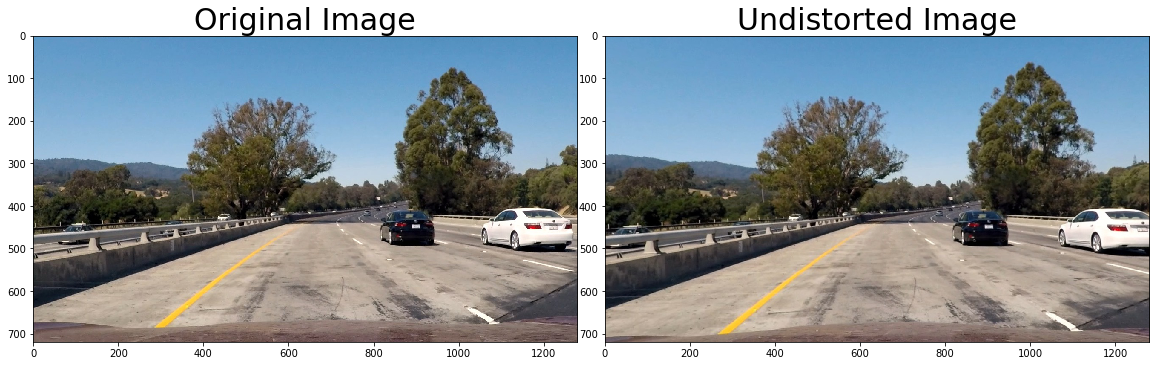

In [5]:
# Display a sample from the undistorted image set.
# read a distorted image
imgPathList = glob.glob(inputPath + '*.jpg')
distortedImg = cv2.imread(imgPathList[3]) # grab a distorted, test image.
#read an the same image, undistorted
imgPathList = glob.glob(outputPath + '*.jpg')
undistortedImg = cv2.imread(imgPathList[3])

display2ImgsSideBySide('Original Image', 'Undistorted Image', distortedImg, undistortedImg)


### 3. Use color transforms, gradients, etc., to create a thresholded binary image:

In [48]:


inputPath = 'output_images/undistorted/'
outputPath = 'output_images/thresholded/'

# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    c_b = threshold(image, thresh_min = 20, thresh_max = 255, s_thresh_min = 200, s_thresh_max = 255)
    outputFileName = outputPath + imgFileName.split('/')[2] # extacting file name
    #c_b = c_b.astype('uint8')
    cv2.imwrite(outputFileName, c_b) # save undistorted image.

print('Done!')




Done!


##### Display a sample from the thresholded image set:

(720, 1280, 3)


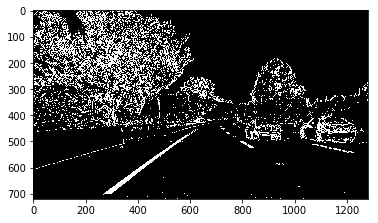

In [53]:

inputPath = 'output_images/thresholded/'

imgPathList = glob.glob(outputPath + '*.jpg')
thresholdImg = cv2.imread(imgPathList[0])
print(thresholdImg.shape)
plt.figure()
plt.imshow(thresholdImg[:,:,2], cmap='gray')


# 4. Apply a perspective transform to rectify binary image ("birds-eye view"):

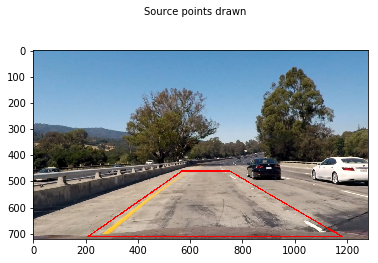

In [54]:
# point to draw the polygon.
pts = np.array([[210,710],[1180,710],[750, 460], [570, 460]], np.int32)

pts = pts.reshape((-1,1,2))
#image with source points drawn on it.
spImg = cv2.polylines(undistortedImg,[pts],True,(0,0,255),4) 
plt.figure()
plt.suptitle('Source points drawn', fontsize=10)
plt.imshow(cv2.cvtColor(spImg, cv2.COLOR_BGR2RGB))

In [55]:
# Applying prespective transfomation. 
from helperFunctions import *


inputPath = 'output_images/thresholded/'
outputPath = 'output_images/transformed/'
Minv = 0
# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    Minv, binary_warped = transform(image)
    outputFileName = outputPath + imgFileName.split('/')[2] # extacting file name
    cv2.imwrite(outputFileName, binary_warped[:,:,2]) # save warped image.
   
print('Done!')

Done!


#### Display a sample from the thresholded image set:

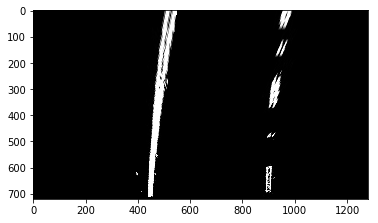

In [56]:
inputPath = 'output_images/transformed/'

imgPathList = glob.glob(outputPath + '*.jpg')
binary_warped = cv2.imread(imgPathList[4]) # grab a distorted, test image.
binary_warped = areaOfInterest(binary_warped)
plt.figure()
plt.imshow(binary_warped, cmap='gray')


## 5. Detect lane pixels and fit to find the lane boundary.

In [57]:
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
left_fit, right_fit, out_img = detectLane(binary_warped)
print("Left Fit: ", left_fit, "Right Fit: ", right_fit)


Left Fit:  [  6.09833007e-05  -1.45667424e-01   5.18375601e+02] Right Fit:  [  1.17814518e-04  -1.93712318e-01   9.75693664e+02]


#####  Visualize the result:

(720, 0)

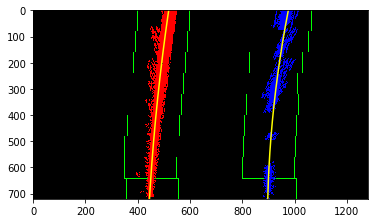

In [58]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 6. Determine the curvature of the lane and vehicle position with respect to center:



In [59]:
ym_per_pix = 20/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/460.0 # meters per pixel in x dimension
y_eval = 720
midx = 710

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 786.851844


### 7. Warp the detected lane boundaries back onto the original image.

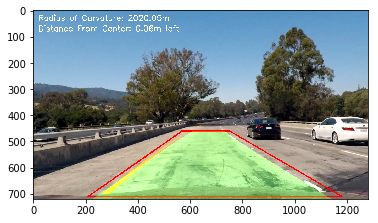

In [60]:
result = drawLane(undistortedImg, binary_warped, left_fit, right_fit, Minv)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))


#### Apply the pipeline on test images:

In [61]:
inputPath = 'test_images/'
outputPath = 'output_images/pipeline_output/'
Minv = 0
# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    laneDetected = pipeline(image, mtx, dist)
    outputFileName = outputPath + imgFileName.split('/')[1] # extacting file name
    cv2.imwrite(outputFileName, laneDetected) # save warped image.
   
print('Done!')


Done!


#### Apply the pipeline on the project video file:

In [62]:
# Read in the video
cap = cv2.VideoCapture('./project_video.mp4')

# Get the input video frame dimentions and define the codec and create VideoWriter object
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH);
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT); 
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4',fourcc, 15.0, (int(w),int(h)))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        #apply pipline to the current frame
        result = pipeline(frame, mtx, dist)
        out.write(result)
    else:
        break

print('done')

done
